<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/tutorials/1-Introduction/Stock_Fundamental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock trading with fundamentals

* This notebook is based on the tutorial: https://towardsdatascience.com/finrl-for-quantitative-finance-tutorial-for-multiple-stock-trading-7b00763b7530

* This project is a result of the almuni-mentored research project at Columbia University, Application of Reinforcement Learning to Finance.
* For detailed explanation, please check out the Medium article: https://medium.com/@mariko.sawada1/automated-stock-trading-with-deep-reinforcement-learning-and-financial-data-a63286ccbe2b



# Content

* [1. Task Discription](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess fundamental Data](#3)        
    * [4.1 Import financial data](#3.1)
    * [4.2 Specify items needed to calculate financial ratios](#3.2)
    * [4.3 Calculate financial ratios](#3.3)
    * [4.4 Deal with NAs and infinite values](#3.4)
    * [4.5 Merge stock price data and ratios into one dataframe](#3.5)
    * [4.6 Calculate market valuation ratios using daily stock price data](#3.6)
* [5. Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6. Train DRL Agents](#5)  
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Task Description

We train a DRL agent for stock trading. The task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Like a human trader analyzes various information, here our agent passively observes many features and learn by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of Dow Jones Industrial Average (DJIA) index. Accessed at the starting date of the testing period.


The data of the single stock that we will use for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close prices and volume.


<a id='1'></a>
# Part 2. Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [57]:
## install finrl library
!pip install "git+https://github.com/AI4Finance-Foundation/FinRL.git"

  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/pip-req-build-_t1zk31l
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/pip-req-build-_t1zk31l
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit eec4c887681dec9ef45bea641cde461c2b2a7084
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/quantopian/pyfolio.git to /private/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/pip-install-rgsjsi66/pyfolio_c24a471fbda843e58e53e30b05e6e3ae
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio.git /private/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/pip-install-rgsjsi66/pyfolio_c24a471fbda843e58e53e30b05e6e3ae
  Resolved https://github.com/quantopian/pyfolio.git to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (


<a id='1.2'></a>
## 2.2. A List of Python Packages
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [58]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# matplotlib.use('Agg')
import datetime

% matplotlib inline
from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl.main import check_and_make_directories
from pprint import pprint
from stable_baselines3.common.logger import configure
import sys

sys.path.append("../FinRL")

import itertools

from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

from finrl.config_tickers import DOW_30_TICKER

<a id='1.4'></a>
## 2.4. Create Folders

In [59]:
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Stock Data from Yahoo Finance
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Retrieving daily stock data from Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()

In [60]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [61]:
TRAIN_START_DATE = "2009-01-01"
TRAIN_END_DATE = "2019-01-01"
TEST_START_DATE = "2019-01-01"
TEST_END_DATE = "2021-01-01"

df = YahooDownloader(start_date=TRAIN_START_DATE, end_date=TEST_END_DATE, ticker_list=DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (88061, 8)


In [62]:
df.shape

(88061, 8)

In [63]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.767330,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,44.523762,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.418562,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.729927,7117200,CAT,4


In [64]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

In [65]:
df.sort_values(["date", "tic"], ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.767330,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,44.523762,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.418562,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.729927,7117200,CAT,4


# Part 4: Preprocess fundamental data
- Import finanical data downloaded from Compustat via WRDS(Wharton Research Data Service)
- Preprocess the dataset and calculate financial ratios
- Add those ratios to the price data preprocessed in Part 3
- Calculate price-related ratios such as P/E and P/B

## 4.1 Import the financial data

In [66]:
# Import fundamental data from my GitHub repository
url = "https://raw.githubusercontent.com/mariko-sawada/FinRL_with_fundamental_data/main/dow_30_fundamental_wrds.csv"

fund = pd.read_csv(url)

/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/ipykernel_48225/4048778421.py:4: DtypeWarning: Columns (16,25) have mixed types. Specify dtype option on import or set low_memory=False.
  fund = pd.read_csv(url)


In [67]:
# Check the imported dataset
fund.head()

,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,tic,...,dvpsxq,mkvaltq,prccq,prchq,prclq,adjex,ggroup,gind,gsector,gsubind
0,1447,19990630,1999,2,12,INDL,C,D,STD,AXP,...,0.225,NaN,130.1250,142.6250,114.5000,3.0,4020,402020,40,40202010
1,1447,19990930,1999,3,12,INDL,C,D,STD,AXP,...,0.000,NaN,135.0000,150.6250,121.8750,3.0,4020,402020,40,40202010
2,1447,19991231,1999,4,12,INDL,C,D,STD,AXP,...,0.225,NaN,166.2500,168.8750,130.2500,3.0,4020,402020,40,40202010
3,1447,20000331,2000,1,12,INDL,C,D,STD,AXP,...,0.225,NaN,148.9375,169.5000,119.5000,3.0,4020,402020,40,40202010
4,1447,20000630,2000,2,12,INDL,C,D,STD,AXP,...,0.080,NaN,52.1250,57.1875,43.9375,1.0,4020,402020,40,40202010


## 4.2 Specify items needed to calculate financial ratios
- To learn more about the data description of the dataset, please check WRDS's website(https://wrds-www.wharton.upenn.edu/). Login will be required.

In [68]:
# List items that are used to calculate financial ratios

items = [
    "datadate",  # Date
    "tic",  # Ticker
    "oiadpq",  # Quarterly operating income
    "revtq",  # Quartely revenue
    "niq",  # Quartely net income
    "atq",  # Total asset
    "teqq",  # Shareholder's equity
    "epspiy",  # EPS(Basic) incl. Extraordinary items
    "ceqq",  # Common Equity
    "cshoq",  # Common Shares Outstanding
    "dvpspq",  # Dividends per share
    "actq",  # Current assets
    "lctq",  # Current liabilities
    "cheq",  # Cash & Equivalent
    "rectq",  # Recievalbles
    "cogsq",  # Cost of  Goods Sold
    "invtq",  # Inventories
    "apq",  # Account payable
    "dlttq",  # Long term debt
    "dlcq",  # Debt in current liabilites
    "ltq",  # Liabilities
]

# Omit items that will not be used
fund_data = fund[items]

In [69]:
# Rename column names for the sake of readability
fund_data = fund_data.rename(
    columns={
        "datadate": "date",  # Date
        "oiadpq": "op_inc_q",  # Quarterly operating income
        "revtq": "rev_q",  # Quartely revenue
        "niq": "net_inc_q",  # Quartely net income
        "atq": "tot_assets",  # Assets
        "teqq": "sh_equity",  # Shareholder's equity
        "epspiy": "eps_incl_ex",  # EPS(Basic) incl. Extraordinary items
        "ceqq": "com_eq",  # Common Equity
        "cshoq": "sh_outstanding",  # Common Shares Outstanding
        "dvpspq": "div_per_sh",  # Dividends per share
        "actq": "cur_assets",  # Current assets
        "lctq": "cur_liabilities",  # Current liabilities
        "cheq": "cash_eq",  # Cash & Equivalent
        "rectq": "receivables",  # Receivalbles
        "cogsq": "cogs_q",  # Cost of  Goods Sold
        "invtq": "inventories",  # Inventories
        "apq": "payables",  # Account payable
        "dlttq": "long_debt",  # Long term debt
        "dlcq": "short_debt",  # Debt in current liabilites
        "ltq": "tot_liabilities",  # Liabilities
    }
)

In [70]:
# Check the data
fund_data.head()

,date,tic,op_inc_q,rev_q,net_inc_q,tot_assets,sh_equity,eps_incl_ex,com_eq,sh_outstanding,...,cur_assets,cur_liabilities,cash_eq,receivables,cogs_q,inventories,payables,long_debt,short_debt,tot_liabilities
0,19990630,AXP,896.0,5564.0,646.0,132452.0,9762.0,2.73,9762.0,449.0,...,NaN,NaN,6096.0,46774.0,4668.0,448.0,22282.0,7005.0,24785.0,122690.0
1,19990930,AXP,906.0,5584.0,648.0,132616.0,9744.0,4.18,9744.0,447.6,...,NaN,NaN,5102.0,48827.0,4678.0,284.0,23587.0,6720.0,24683.0,122872.0
2,19991231,AXP,845.0,6009.0,606.0,148517.0,10095.0,5.54,10095.0,446.9,...,NaN,NaN,10391.0,54033.0,5164.0,277.0,25719.0,4685.0,32437.0,138422.0
3,20000331,AXP,920.0,6021.0,656.0,150662.0,10253.0,1.48,10253.0,444.7,...,NaN,NaN,7425.0,53663.0,5101.0,315.0,26379.0,5670.0,29342.0,140409.0
4,20000630,AXP,1046.0,6370.0,740.0,148553.0,10509.0,1.05,10509.0,1333.0,...,NaN,NaN,6841.0,54286.0,5324.0,261.0,29536.0,5336.0,26170.0,138044.0


## 4.3 Calculate financial ratios
- For items from Profit/Loss statements, we calculate LTM (Last Twelve Months) and use them to derive profitability related ratios such as Operating Maring and ROE. For items from balance sheets, we use the numbers on the day.
- To check the definitions of the financial ratios calculated here, please refer to CFI's website: https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/

In [71]:
# Calculate financial ratios
date = pd.to_datetime(fund_data["date"], format="%Y%m%d")

tic = fund_data["tic"].to_frame("tic")

# Profitability ratios
# Operating Margin
OPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name="OPM")
for i in range(0, fund_data.shape[0]):
    if i - 3 < 0:
        OPM[i] = np.nan
    elif fund_data.iloc[i, 1] != fund_data.iloc[i - 3, 1]:
        OPM.iloc[i] = np.nan
    else:
        OPM.iloc[i] = np.sum(fund_data["op_inc_q"].iloc[i - 3 : i]) / np.sum(fund_data["rev_q"].iloc[i - 3 : i])

# Net Profit Margin
NPM = pd.Series(np.empty(fund_data.shape[0], dtype=object), name="NPM")
for i in range(0, fund_data.shape[0]):
    if i - 3 < 0:
        NPM[i] = np.nan
    elif fund_data.iloc[i, 1] != fund_data.iloc[i - 3, 1]:
        NPM.iloc[i] = np.nan
    else:
        NPM.iloc[i] = np.sum(fund_data["net_inc_q"].iloc[i - 3 : i]) / np.sum(fund_data["rev_q"].iloc[i - 3 : i])

# Return On Assets
ROA = pd.Series(np.empty(fund_data.shape[0], dtype=object), name="ROA")
for i in range(0, fund_data.shape[0]):
    if i - 3 < 0:
        ROA[i] = np.nan
    elif fund_data.iloc[i, 1] != fund_data.iloc[i - 3, 1]:
        ROA.iloc[i] = np.nan
    else:
        ROA.iloc[i] = np.sum(fund_data["net_inc_q"].iloc[i - 3 : i]) / fund_data["tot_assets"].iloc[i]

# Return on Equity
ROE = pd.Series(np.empty(fund_data.shape[0], dtype=object), name="ROE")
for i in range(0, fund_data.shape[0]):
    if i - 3 < 0:
        ROE[i] = np.nan
    elif fund_data.iloc[i, 1] != fund_data.iloc[i - 3, 1]:
        ROE.iloc[i] = np.nan
    else:
        ROE.iloc[i] = np.sum(fund_data["net_inc_q"].iloc[i - 3 : i]) / fund_data["sh_equity"].iloc[i]

    # For calculating valuation ratios in the next subpart, calculate per share items in advance
# Earnings Per Share
EPS = fund_data["eps_incl_ex"].to_frame("EPS")

# Book Per Share
BPS = (fund_data["com_eq"] / fund_data["sh_outstanding"]).to_frame("BPS")  # Need to check units

# Dividend Per Share
DPS = fund_data["div_per_sh"].to_frame("DPS")

# Liquidity ratios
# Current ratio
cur_ratio = (fund_data["cur_assets"] / fund_data["cur_liabilities"]).to_frame("cur_ratio")

# Quick ratio
quick_ratio = ((fund_data["cash_eq"] + fund_data["receivables"]) / fund_data["cur_liabilities"]).to_frame("quick_ratio")

# Cash ratio
cash_ratio = (fund_data["cash_eq"] / fund_data["cur_liabilities"]).to_frame("cash_ratio")

# Efficiency ratios
# Inventory turnover ratio
inv_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name="inv_turnover")
for i in range(0, fund_data.shape[0]):
    if i - 3 < 0:
        inv_turnover[i] = np.nan
    elif fund_data.iloc[i, 1] != fund_data.iloc[i - 3, 1]:
        inv_turnover.iloc[i] = np.nan
    else:
        inv_turnover.iloc[i] = np.sum(fund_data["cogs_q"].iloc[i - 3 : i]) / fund_data["inventories"].iloc[i]

# Receivables turnover ratio
acc_rec_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name="acc_rec_turnover")
for i in range(0, fund_data.shape[0]):
    if i - 3 < 0:
        acc_rec_turnover[i] = np.nan
    elif fund_data.iloc[i, 1] != fund_data.iloc[i - 3, 1]:
        acc_rec_turnover.iloc[i] = np.nan
    else:
        acc_rec_turnover.iloc[i] = np.sum(fund_data["rev_q"].iloc[i - 3 : i]) / fund_data["receivables"].iloc[i]

# Payable turnover ratio
acc_pay_turnover = pd.Series(np.empty(fund_data.shape[0], dtype=object), name="acc_pay_turnover")
for i in range(0, fund_data.shape[0]):
    if i - 3 < 0:
        acc_pay_turnover[i] = np.nan
    elif fund_data.iloc[i, 1] != fund_data.iloc[i - 3, 1]:
        acc_pay_turnover.iloc[i] = np.nan
    else:
        acc_pay_turnover.iloc[i] = np.sum(fund_data["cogs_q"].iloc[i - 3 : i]) / fund_data["payables"].iloc[i]

## Leverage financial ratios
# Debt ratio
debt_ratio = (fund_data["tot_liabilities"] / fund_data["tot_assets"]).to_frame("debt_ratio")

# Debt to Equity ratio
debt_to_equity = (fund_data["tot_liabilities"] / fund_data["sh_equity"]).to_frame("debt_to_equity")

/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/ipykernel_48225/1057739536.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])
/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/ipykernel_48225/1057739536.py:15: RuntimeWarning: invalid value encountered in double_scalars
  OPM.iloc[i] = np.sum(fund_data['op_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])
/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/ipykernel_48225/1057739536.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])
/var/folders/9c/z5w432ls60300pg8dcrpkhkr0000gn/T/ipykernel_48225/1057739536.py:25: RuntimeWarning: invalid value encountered in double_scalars
  NPM.iloc[i] = np.sum(fund_data['net_inc_q'].iloc[i-3:i])/np.sum(fund_data['rev_q'].iloc[i-3:i])
/var/folders/9c/z5w432ls60300pg8dcrp

In [72]:
# Create a dataframe that merges all the ratios
ratios = pd.concat(
    [
        date,
        tic,
        OPM,
        NPM,
        ROA,
        ROE,
        EPS,
        BPS,
        DPS,
        cur_ratio,
        quick_ratio,
        cash_ratio,
        inv_turnover,
        acc_rec_turnover,
        acc_pay_turnover,
        debt_ratio,
        debt_to_equity,
    ],
    axis=1,
)

In [73]:
# Check the ratio data
ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,NaN,NaN,NaN,NaN,2.73,21.741648,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926298,12.568121
1,1999-09-30,AXP,NaN,NaN,NaN,NaN,4.18,21.769437,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.926525,12.610016
2,1999-12-31,AXP,NaN,NaN,NaN,NaN,5.54,22.588946,0.225,NaN,NaN,NaN,NaN,NaN,NaN,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,NaN,NaN,NaN,46.063492,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.012857,0.181749,1.05,7.883721,0.080,NaN,NaN,NaN,57.252874,0.324467,0.505925,0.929258,13.135788


In [74]:
ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,inf,6.11635,2.697537,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,inf,5.063131,1.889507,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.52129,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,inf,5.628571,2.730366,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.094422,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,inf,4.725314,2.347866,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.095218,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,inf,4.844961,2.367357,0.529946,1.127414


## 4.4 Deal with NAs and infinite values
- We replace N/A and infinite values with zero.

In [75]:
# Replace NAs infinite values with zero
final_ratios = ratios.copy()
final_ratios = final_ratios.fillna(0)
final_ratios = final_ratios.replace(np.inf, 0)

In [76]:
final_ratios.head()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
0,1999-06-30,AXP,0.000000,0.000000,0.000000,0.000000,2.73,21.741648,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926298,12.568121
1,1999-09-30,AXP,0.000000,0.000000,0.000000,0.000000,4.18,21.769437,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.926525,12.610016
2,1999-12-31,AXP,0.000000,0.000000,0.000000,0.000000,5.54,22.588946,0.225,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.932028,13.711937
3,2000-03-31,AXP,0.154281,0.110742,0.012611,0.185312,1.48,23.055993,0.225,0.0,0.0,0.0,46.063492,0.319717,0.550059,0.931947,13.694431
4,2000-06-30,AXP,0.151641,0.108436,0.012857,0.181749,1.05,7.883721,0.080,0.0,0.0,0.0,57.252874,0.324467,0.505925,0.929258,13.135788


In [77]:
final_ratios.tail()

,date,tic,OPM,NPM,ROA,ROE,EPS,BPS,DPS,cur_ratio,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity
2451,2020-03-31,V,0.667517,0.521213,0.129058,0.271736,2.85,13.647142,0.30,1.248714,1.140070,0.955150,0.0,6.116350,2.697537,0.525062,1.105537
2452,2020-06-30,V,0.668385,0.519867,0.120448,0.264075,3.92,14.203947,0.30,1.553478,1.443292,1.221925,0.0,5.063131,1.889507,0.543886,1.192433
2453,2020-09-30,V,0.654464,0.521290,0.107873,0.241066,4.90,14.653484,0.30,1.905238,1.784838,1.579807,0.0,5.628571,2.730366,0.552515,1.234714
2454,2020-12-31,V,0.638994,0.480876,0.094422,0.201545,1.42,15.908283,0.32,2.121065,1.969814,1.700081,0.0,4.725314,2.347866,0.531507,1.134505
2455,2021-03-31,V,0.640128,0.488704,0.095218,0.202568,2.80,16.088525,0.32,2.116356,1.954292,1.700574,0.0,4.844961,2.367357,0.529946,1.127414


## 4.5 Merge stock price data and ratios into one dataframe
- Merge the price dataframe preprocessed in Part 3 and the ratio dataframe created in this part
- Since the prices are daily and ratios are quartely, we have NAs in the ratio columns after merging the two dataframes. We deal with this by backfilling the ratios.

In [78]:
list_ticker = df["tic"].unique().tolist()
list_date = list(pd.date_range(df["date"].min(), df["date"].max()))
combination = list(itertools.product(list_date, list_ticker))

# Merge stock price data and ratios into one dataframe
processed_full = pd.DataFrame(combination, columns=["date", "tic"]).merge(df, on=["date", "tic"], how="left")
processed_full = processed_full.merge(final_ratios, how="left", on=["date", "tic"])
processed_full = processed_full.sort_values(["tic", "date"])

# Backfill the ratio data to make them daily
processed_full = processed_full.bfill(axis="rows")

## 4.6 Calculate market valuation ratios using daily stock price data 

In [79]:
# Calculate P/E, P/B and dividend yield using daily closing price
processed_full["PE"] = processed_full["close"] / processed_full["EPS"]
processed_full["PB"] = processed_full["close"] / processed_full["BPS"]
processed_full["Div_yield"] = processed_full["DPS"] / processed_full["close"]

# Drop per share items used for the above calculation
processed_full = processed_full.drop(columns=["day", "EPS", "BPS", "DPS"])
# Replace NAs infinite values with zero
processed_full = processed_full.copy()
processed_full = processed_full.fillna(0)
processed_full = processed_full.replace(np.inf, 0)

In [80]:
# Check the final data
processed_full.sort_values(["date", "tic"], ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.767330,746015200.0,0.217886,0.163846,0.103222,...,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.636168,0.101527,0.000000
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.523762,6547900.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,143.625038,4.123355,0.004043
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.418562,10955700.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,49.737297,1.427916,0.011674
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,0.047307,0.032525,0.026400,...,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,39.012755,-35.751050,0.012374
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.729927,7117200.0,0.124545,0.066662,0.040891,...,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-166.999616,3.062595,0.013237
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,0.234698,0.196418,0.097593,...,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,13.500000,1.351255,0.000000
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.043802,40980600.0,0.234698,0.196418,0.097593,...,2.498162,2.170759,9.054201,6.844634,16.036800,0.400215,0.667591,19.117146,1.913492,0.000000
7,2009-01-02,CVX,74.230003,77.300003,73.580002,44.404144,13695900.0,0.141417,0.097223,0.117691,...,0.952878,0.373760,23.920348,13.387209,11.276861,0.449174,0.815455,48.265374,1.019502,0.014638
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597498,9796600.0,0.167221,0.102157,0.045834,...,0.815629,0.330748,11.310223,5.725855,4.287167,0.455848,0.837721,26.072782,1.126511,0.016992
9,2009-01-02,DOW,52.750000,53.500000,49.500000,41.373940,2350800.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,179.886694,0.000000,0.000000


<a id='4'></a>
# Part 5. A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## 5.1 Data Split
- Training data period: 2009-01-01 to 2019-01-01
- Trade data period: 2019-01-01 to 2020-12-31

In [81]:
train_data = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
# Check the length of the two datasets
print(len(train_data))
print(len(trade_data))

109530
21930


In [82]:
train_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.767330,746015200.0,0.217886,0.163846,0.103222,...,2.039779,1.818995,54.403846,8.972003,4.269115,0.437727,0.778495,0.636168,0.101527,0.000000
0,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.523762,6547900.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,143.625038,4.123355,0.004043
0,2009-01-02,AXP,18.570000,19.520000,18.400000,15.418562,10955700.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,49.737297,1.427916,0.011674
0,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,0.047307,0.032525,0.026400,...,0.368463,0.148507,2.329670,6.815203,2.076967,1.009198,-109.722986,39.012755,-35.751050,0.012374
0,2009-01-02,CAT,44.910000,46.980000,44.709999,31.729927,7117200.0,0.124545,0.066662,0.040891,...,0.890488,0.163158,3.540791,2.460351,8.472455,0.893715,9.089489,-166.999616,3.062595,0.013237


In [83]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,38.168354,148158800.0,0.258891,0.227773,0.133360,...,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.696769,1.661179,0.019126
0,2019-01-01,AMGN,192.520004,193.199997,188.949997,171.580246,3009100.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,553.484664,15.890083,0.001049
0,2019-01-01,AXP,93.910004,96.269997,93.769997,90.403214,4175400.0,0.203479,0.160494,0.026811,...,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,49.946527,3.405684,0.004314
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645172,3292200.0,0.116496,0.102682,0.066409,...,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.019834,1418.196409,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,114.177399,4783200.0,0.186871,0.107064,0.056932,...,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,34.704376,4.228506,0.007532


## 5.2 Set up the training environment

In [84]:
import gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
from stable_baselines3.common.vec_env import DummyVecEnv
from experiments.StockTradingEnv import StockTradingEnv

matplotlib.use("Agg")

# from stable_baselines3.common import logger

In [85]:
ratio_list = [
    "OPM",
    "NPM",
    "ROA",
    "ROE",
    "cur_ratio",
    "quick_ratio",
    "cash_ratio",
    "inv_turnover",
    "acc_rec_turnover",
    "acc_pay_turnover",
    "debt_ratio",
    "debt_to_equity",
    "PE",
    "PB",
    "Div_yield",
]

stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2 * stock_dimension + len(ratio_list) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 511


In [86]:
# Parameters for the environment
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": ratio_list,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
}

# Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df=train_data, **env_kwargs)

## Environment for Training



In [87]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [88]:
# Set up the agent using DRLAgent() class using the environment created in the previous part
agent = DRLAgent(env=env_train)

if_using_a2c = False
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = True

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)

### Model 1: PPO

In [89]:
agent = DRLAgent(env=env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo", model_kwargs=PPO_PARAMS)

if if_using_ppo:
    # set up logger
    tmp_path = RESULTS_DIR + "/ppo"
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [90]:
trained_ppo = agent.train_model(model=model_ppo, tb_log_name="ppo", total_timesteps=50000) if if_using_ppo else None

### Model 2: DDPG

In [91]:
agent = DRLAgent(env=env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
    # set up logger
    tmp_path = RESULTS_DIR + "/ddpg"
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [92]:
trained_ddpg = agent.train_model(model=model_ddpg, tb_log_name="ddpg", total_timesteps=50000) if if_using_ddpg else None

### Model 3: A2C


In [93]:
agent = DRLAgent(env=env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
    # set up logger
    tmp_path = RESULTS_DIR + "/a2c"
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [94]:
trained_a2c = agent.train_model(model=model_a2c, tb_log_name="a2c", total_timesteps=50000) if if_using_a2c else None

### Model 4: TD3

In [95]:
agent = DRLAgent(env=env_train)
TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}

model_td3 = agent.get_model("td3", model_kwargs=TD3_PARAMS)

if if_using_td3:
    # set up logger
    tmp_path = RESULTS_DIR + "/td3"
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [96]:
trained_td3 = agent.train_model(model=model_td3, tb_log_name="td3", total_timesteps=30000) if if_using_td3 else None

### Model 5: SAC

In [97]:
agent = DRLAgent(env=env_train)
import numpy as np


def fun():
    pass


SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac", model_kwargs=SAC_PARAMS)

if if_using_sac:
    # set up logger
    tmp_path = RESULTS_DIR + "/sac"
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [98]:
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=30000) if if_using_sac else None

--------------------------------------
| time/              |               |
|    episodes        | 4             |
|    fps             | 33            |
|    time_elapsed    | 432           |
|    total_timesteps | 14604         |
| train/             |               |
|    actor_loss      | 366           |
|    critic_loss     | 27.7          |
|    ent_coef        | 0.0792        |
|    ent_coef_loss   | -117          |
|    learning_rate   | 0.0001        |
|    n_updates       | 14503         |
|    reward          | -0.0055717085 |
--------------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 35       |
|    time_elapsed    | 813      |
|    total_timesteps | 29208    |
| train/             |          |
|    actor_loss      | 106      |
|    critic_loss     | 5.15     |
|    ent_coef        | 0.0186   |
|    ent_coef_loss   | -164     |
|    learning_rate   | 0.0001   |
|    n_

In [109]:
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")
trained_sac.save(f"trained_sac_{now}")

## Trading
Assume that we have $1,000,000 initial capital at TEST_START_DATE. We use the DDPG model to trade Dow jones 30 stocks.

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [99]:
trade_data = data_split(processed_full, TEST_START_DATE, TEST_END_DATE)
e_trade_gym = StockTradingEnv(df=trade_data, **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [100]:
trade_data.head()

,date,tic,open,high,low,close,volume,OPM,NPM,ROA,...,quick_ratio,cash_ratio,inv_turnover,acc_rec_turnover,acc_pay_turnover,debt_ratio,debt_to_equity,PE,PB,Div_yield
0,2019-01-01,AAPL,38.722500,39.712502,38.557499,38.168354,148158800.0,0.258891,0.227773,0.133360,...,1.134347,0.854114,23.571867,7.620024,3.781658,0.690466,2.230663,5.696769,1.661179,0.019126
0,2019-01-01,AMGN,192.520004,193.199997,188.949997,171.580246,3009100.0,0.093973,0.072040,0.014094,...,0.000000,0.000000,0.000000,0.351354,0.653355,0.869784,6.679531,553.484664,15.890083,0.001049
0,2019-01-01,AXP,93.910004,96.269997,93.769997,90.403214,4175400.0,0.203479,0.160494,0.026811,...,0.000000,0.000000,0.000000,0.231669,0.279424,0.887329,7.875371,49.946527,3.405684,0.004314
0,2019-01-01,BA,316.190002,323.950012,313.709991,314.645172,3292200.0,0.116496,0.102682,0.066409,...,0.262465,0.092436,0.933164,5.468453,4.151637,0.998070,517.142241,83.019834,1418.196409,0.006531
0,2019-01-01,CAT,124.029999,127.879997,123.000000,114.177399,4783200.0,0.186871,0.107064,0.056932,...,0.919490,0.266175,2.135008,2.339630,3.660183,0.803394,4.086316,34.704376,4.228506,0.007532


In [108]:
df_account_value_ppo, df_actions_ppo = (
    DRLAgent.DRL_prediction(model=trained_ppo, environment=e_trade_gym) if if_using_ppo else [None, None]
)

df_account_value_ddpg, df_actions_ddpg = (
    DRLAgent.DRL_prediction(model=trained_ddpg, environment=e_trade_gym) if if_using_ddpg else [None, None]
)

df_account_value_a2c, df_actions_a2c = (
    DRLAgent.DRL_prediction(model=trained_a2c, environment=e_trade_gym) if if_using_a2c else [None, None]
)

df_account_value_td3, df_actions_td3 = (
    DRLAgent.DRL_prediction(model=trained_td3, environment=e_trade_gym) if if_using_td3 else [None, None]
)

df_account_value_sac, df_actions_sac = (
    DRLAgent.DRL_prediction(model=trained_sac, environment=e_trade_gym) if if_using_sac else [None, None]
)

/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/_pydevd_bundle/pydev

KeyboardInterrupt: 

In [102]:
# df_account_value_ppo.shape
# df_account_value_ddpg.shape
# df_account_value_a2c.shape
# df_account_value_td3.shape
# df_account_value_sac.shape

In [103]:
# df_account_value_ppo.tail()
# df_account_value_ddpg.tail()
# df_account_value_a2c.tail()
# df_account_value_td3.tail()
# df_account_value_sac.tail()

In [104]:
# df_actions_ppo.head()
# df_actions_ddpg.head()
# df_actions_a2c.head()
# df_actions_td3.head()
# df_actions_sac.head()

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [105]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

if if_using_ppo:
    print("\n ppo:")
    perf_stats_all_ppo = backtest_stats(account_value=df_account_value_ppo)
    perf_stats_all_ppo = pd.DataFrame(perf_stats_all_ppo)
    perf_stats_all_ppo.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_ppo_" + now + ".csv")

if if_using_ddpg:
    print("\n ddpg:")
    perf_stats_all_ddpg = backtest_stats(account_value=df_account_value_ddpg)
    perf_stats_all_ddpg = pd.DataFrame(perf_stats_all_ddpg)
    perf_stats_all_ddpg.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_ddpg_" + now + ".csv")

if if_using_a2c:
    print("\n a2c:")
    perf_stats_all_a2c = backtest_stats(account_value=df_account_value_a2c)
    perf_stats_all_a2c = pd.DataFrame(perf_stats_all_a2c)
    perf_stats_all_a2c.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_a2c_" + now + ".csv")

if if_using_td3:
    print("\n atd3:")
    perf_stats_all_td3 = backtest_stats(account_value=df_account_value_td3)
    perf_stats_all_td3 = pd.DataFrame(perf_stats_all_td3)
    perf_stats_all_td3.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_td3_" + now + ".csv")

if if_using_sac:
    print("\n sac:")
    perf_stats_all_sac = backtest_stats(account_value=df_account_value_sac)
    perf_stats_all_sac = pd.DataFrame(perf_stats_all_sac)
    perf_stats_all_sac.to_csv("./" + config.RESULTS_DIR + "/perf_stats_all_sac_" + now + ".csv")

==============Get Backtest Results===========

 sac:
Annual return          0.094768
Cumulative returns     0.300364
Annual volatility      0.261273
Sharpe ratio           0.478686
Calmar ratio           0.232513
Stability              0.031439
Max drawdown          -0.407580
Omega ratio            1.136277
Sortino ratio          0.663560
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.947480
Daily value at risk   -0.032421
dtype: float64


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [106]:
# baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(ticker="^DJI", start=TEST_START_DATE, end=TEST_END_DATE)

stats = backtest_stats(baseline_df, value_col_name="close")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)
Annual return          0.144674
Cumulative returns     0.310981
Annual volatility      0.274619
Sharpe ratio           0.631418
Calmar ratio           0.390102
Stability              0.116677
Max drawdown          -0.370862
Omega ratio            1.149365
Sortino ratio          0.870084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.860710
Daily value at risk   -0.033911
dtype: float64


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (505, 8)


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/finrl/meta/preprocessor/yahoodownloader.py:54: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2019-01-01
End date,2020-12-31
Total months,34
,Backtest
Annual return,9.477%
Cumulative returns,30.036%
Annual volatility,26.127%
Sharpe ratio,0.48
Calmar ratio,0.23
Stability,0.03
Max drawdown,-40.758%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,40.76,2020-02-19,2020-03-21,2020-11-24,200
1,7.66,2019-07-23,2019-08-14,2019-11-05,76
2,6.45,2019-02-23,2019-06-01,2019-06-20,84
3,4.17,2020-01-16,2020-01-31,2020-02-12,20
4,2.53,2019-11-26,2019-12-03,2019-12-12,13


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/l

Stress Events,mean,min,max
New Normal,0.05%,-14.14%,12.84%


/Users/zlapik/my-drive-zdenda-lapes/0-todo/ai-investing/venv_2/lib/python3.10/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


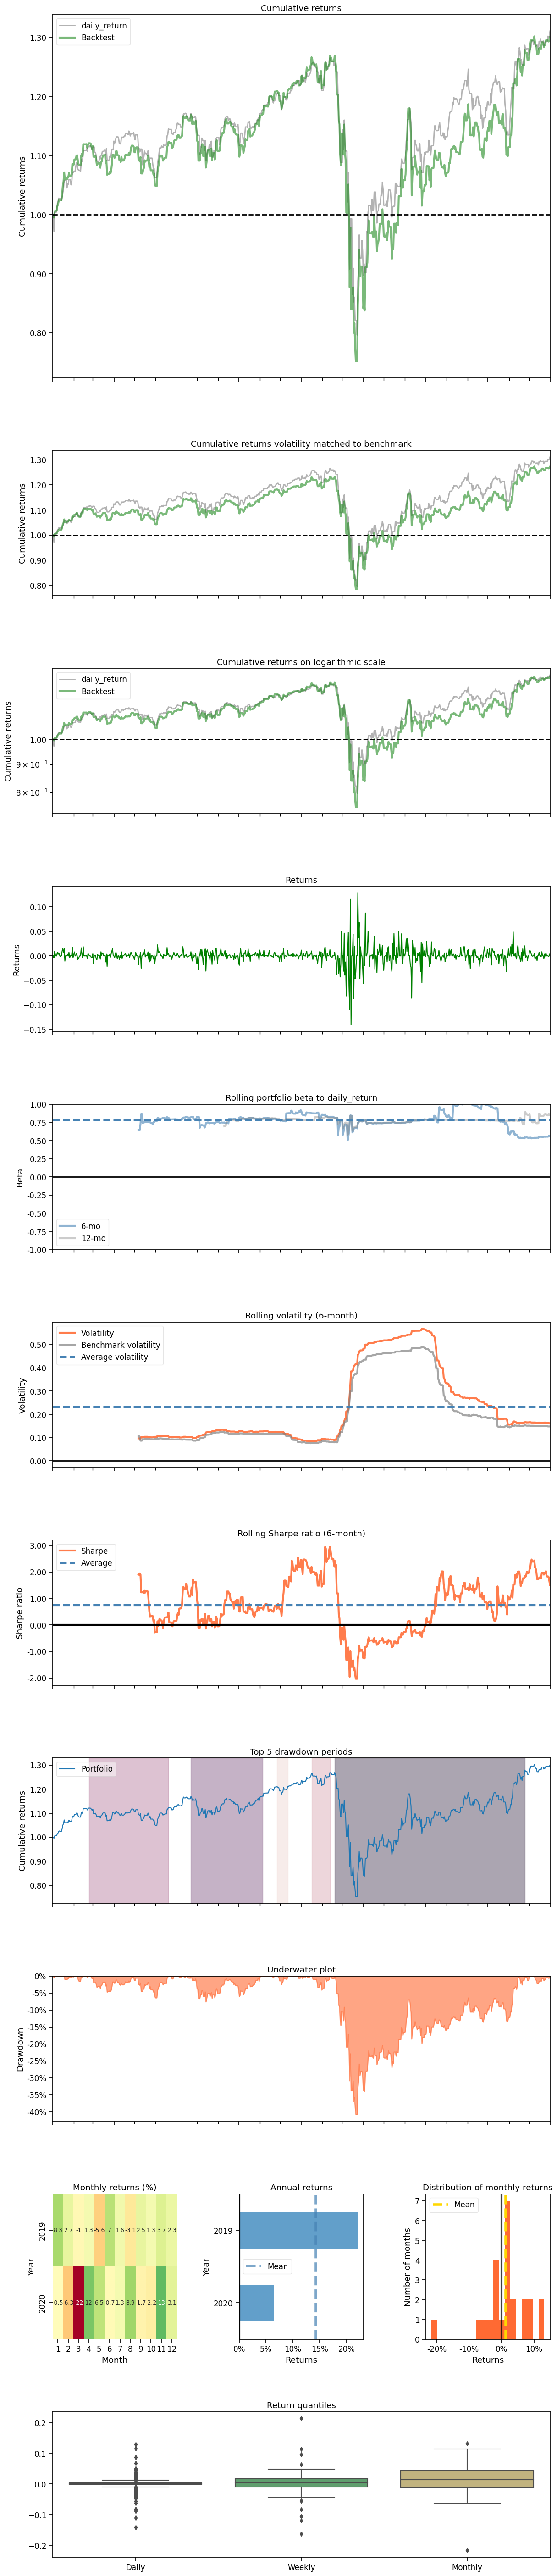

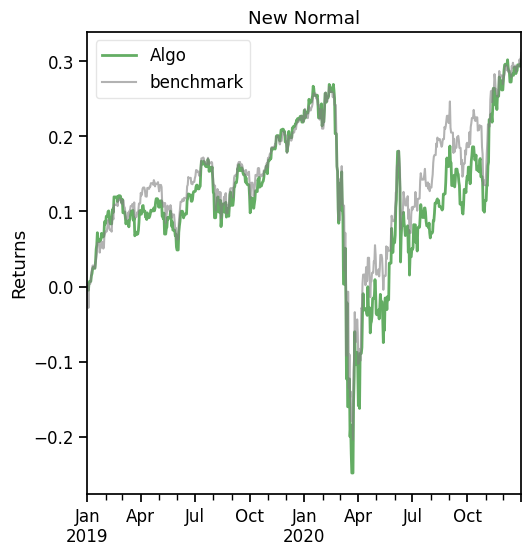

In [107]:
print("==============Compare to DJIA===========")
% matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX

if if_using_ppo:
    backtest_plot(
        df_account_value_ppo, baseline_ticker="^DJI", baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE
    )

if if_using_ddpg:
    backtest_plot(
        df_account_value_ddpg, baseline_ticker="^DJI", baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE
    )

if if_using_a2c:
    backtest_plot(
        df_account_value_a2c, baseline_ticker="^DJI", baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE
    )

if if_using_td3:
    backtest_plot(
        df_account_value_td3, baseline_ticker="^DJI", baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE
    )

if if_using_sac:
    backtest_plot(
        df_account_value_sac, baseline_ticker="^DJI", baseline_start=TEST_START_DATE, baseline_end=TEST_END_DATE
    )